<a href="https://colab.research.google.com/github/MKolaksazov/Machine-Learning/blob/master/Stock%20Prediction/bitfinex_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download historical cryptocurrency data and use it to learn to trade Bitcoin automatically

In [1]:
! pip install bitfinex-tencars

In [2]:
import bitfinex
import time
import datetime
import pandas as pd

In [3]:
# Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2()

No keys, only access to public API functions


In [23]:
# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
TIMEFRAME = '1h'#,'4h','1h','15m','1m'
TIMEFRAME_S = 3600

In [16]:
# Define the start date
t_start = datetime.datetime(2014, 9, 1, 0, 0) #(2018, 9, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

In [17]:
# Define the end date
t_stop = datetime.datetime(2020, 10, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [18]:
# Download OHCL data from API
result = api_v2.candles(symbol=pair, interval=TIMEFRAME, limit=1000, start=t_start, end=t_stop)

In [19]:
# Convert list of data to pandas dataframe
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')

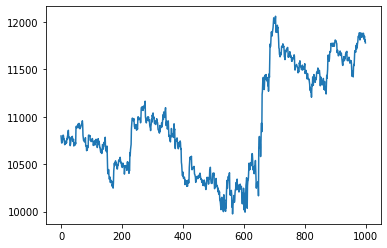

In [20]:
# we can plot our downloaded data
import matplotlib.pyplot as plt
plt.plot(df['Open'],'-')
plt.show()

In [21]:
def fetch_data(start, stop, symbol, interval, TIMEFRAME_S):
    limit = 1000    # We want the maximum of 1000 data points
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()
    hour = TIMEFRAME_S * 1000
    step = hour * limit
    data = []

    total_steps = (stop-start)/hour
    while total_steps > 0:
        if total_steps < limit: # recalculating ending steps
            step = total_steps * hour

        end = start + step
        data += api_v2.candles(symbol=symbol, interval=interval, limit=limit, start=start, end=end)
        print(pd.to_datetime(start, unit='ms'), pd.to_datetime(end, unit='ms'), "steps left:", total_steps)
        start = start + step
        total_steps -= limit
        time.sleep(1.5)
    return data

In [24]:
result = fetch_data(t_start, t_stop, pair, TIMEFRAME, TIMEFRAME_S)
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df.drop_duplicates(inplace=True)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.to_csv(f"{pair}_{TIMEFRAME}.csv")

No keys, only access to public API functions
2014-09-01 00:00:00 2014-10-12 16:00:00 steps left: 53328.0
2014-10-12 16:00:00 2014-11-23 08:00:00 steps left: 52328.0
2014-11-23 08:00:00 2015-01-04 00:00:00 steps left: 51328.0
2015-01-04 00:00:00 2015-02-14 16:00:00 steps left: 50328.0
2015-02-14 16:00:00 2015-03-28 08:00:00 steps left: 49328.0
2015-03-28 08:00:00 2015-05-09 00:00:00 steps left: 48328.0
2015-05-09 00:00:00 2015-06-19 16:00:00 steps left: 47328.0
2015-06-19 16:00:00 2015-07-31 08:00:00 steps left: 46328.0
2015-07-31 08:00:00 2015-09-11 00:00:00 steps left: 45328.0
2015-09-11 00:00:00 2015-10-22 16:00:00 steps left: 44328.0
2015-10-22 16:00:00 2015-12-03 08:00:00 steps left: 43328.0
2015-12-03 08:00:00 2016-01-14 00:00:00 steps left: 42328.0
2016-01-14 00:00:00 2016-02-24 16:00:00 steps left: 41328.0
2016-02-24 16:00:00 2016-04-06 08:00:00 steps left: 40328.0
2016-04-06 08:00:00 2016-05-18 00:00:00 steps left: 39328.0
2016-05-18 00:00:00 2016-06-28 16:00:00 steps left: 383

In [26]:
from multiprocessing import Process, Pipe
import time
import random

class Environment(Process): # creating environment class for multiprocessing
    def __init__(self, env_idx, child_conn):
        super(Environment, self).__init__()
        self.env_idx = env_idx
        self.child_conn = child_conn

    def run(self):
        super(Environment, self).run()
        while True:
            number = self.child_conn.recv()
            self.child_conn.send(number*2)

if __name__ == "__main__":
    works, parent_conns, child_conns = [], [], []
    
    for idx in range(2):
        parent_conn, child_conn = Pipe() # creating a communication pipe
        work = Environment(idx, child_conn) # creating new process 
        work.start() # starting process 
        works.append(work) # saving started procsses to list
        parent_conns.append(parent_conn) # saving communication pipe refference to list
        child_conns.append(child_conn) # saving communication pipe refference to list

    while True:
        for worker_id, parent_conn in enumerate(parent_conns):
            r = random.randint(0, 10) # creating random number between 0 and 10
            parent_conn.send(r) # sending message with random nuber to worker_id running process
            
        time.sleep(1)

        for worker_id, parent_conn in enumerate(parent_conns):
            result = parent_conn.recv() # reading received message from worker_id process
            print(f"From {worker_id} worker received {result}")

Process Environment-4:
Traceback (most recent call last):
Process Environment-3:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-26-40beec1b546e>", line 14, in run
    number = self.child_conn.recv()


From 0 worker received 20
From 1 worker received 6


  File "<ipython-input-26-40beec1b546e>", line 14, in run
    number = self.child_conn.recv()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()


KeyboardInterrupt: ignored

  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt


In [ ]:
from multiprocessing import Process, Pipe

class Environment(Process):
    def __init__(self, env_idx, child_conn, env, training_batch_size, visualize):
        super(Environment, self).__init__()
        self.env = env
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.training_batch_size = training_batch_size
        self.visualize = visualize

    def run(self):
        super(Environment, self).run()
        state = self.env.reset(env_steps_size = self.training_batch_size)
        self.child_conn.send(state)
        while True:
            reset, net_worth, episode_orders = 0, 0, 0
            action = self.child_conn.recv()
            if self.env_idx == 0:
                self.env.render(self.visualize)
            state, reward, done = self.env.step(action)

            if done or self.env.current_step == self.env.end_step:
                net_worth = self.env.net_worth
                episode_orders = self.env.episode_orders
                state = self.env.reset(env_steps_size = self.training_batch_size)
                reset = 1

            self.child_conn.send([state, reward, done, reset, net_worth, episode_orders])

In [ ]:
def train_multiprocessing(CustomEnv, agent, train_df, num_worker=4, training_batch_size=500, visualize=False, EPISODES=10000):
    works, parent_conns, child_conns = [], [], []
    episode = 0
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth

    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        env = CustomEnv(train_df, lookback_window_size=agent.lookback_window_size)
        work = Environment(idx, child_conn, env, training_batch_size, visualize)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    agent.create_writer(env.initial_balance, env.normalize_value, EPISODES) # create TensorBoard writer

    states =        [[] for _ in range(num_worker)]
    next_states =   [[] for _ in range(num_worker)]
    actions =       [[] for _ in range(num_worker)]
    rewards =       [[] for _ in range(num_worker)]
    dones =         [[] for _ in range(num_worker)]
    predictions =   [[] for _ in range(num_worker)]

    state = [0 for _ in range(num_worker)]
    for worker_id, parent_conn in enumerate(parent_conns):
        state[worker_id] = parent_conn.recv()

    while episode < EPISODES:
        predictions_list = agent.Actor.actor_predict(np.reshape(state, [num_worker]+[_ for _ in state[0].shape]))
        actions_list = [np.random.choice(agent.action_space, p=i) for i in predictions_list]

        for worker_id, parent_conn in enumerate(parent_conns):
            parent_conn.send(actions_list[worker_id])
            action_onehot = np.zeros(agent.action_space.shape[0])
            action_onehot[actions_list[worker_id]] = 1
            actions[worker_id].append(action_onehot)
            predictions[worker_id].append(predictions_list[worker_id])

        for worker_id, parent_conn in enumerate(parent_conns):
            next_state, reward, done, reset, net_worth, episode_orders = parent_conn.recv()
            states[worker_id].append(np.expand_dims(state[worker_id], axis=0))
            next_states[worker_id].append(np.expand_dims(next_state, axis=0))
            rewards[worker_id].append(reward)
            dones[worker_id].append(done)
            state[worker_id] = next_state

            if reset:
                episode += 1
                a_loss, c_loss = agent.replay(states[worker_id], actions[worker_id], rewards[worker_id], predictions[worker_id], dones[worker_id], next_states[worker_id])
                total_average.append(net_worth)
                average = np.average(total_average)

                agent.writer.add_scalar('Data/average net_worth', average, episode)
                agent.writer.add_scalar('Data/episode_orders', episode_orders, episode)
                
                print("episode: {:<5} worker: {:<1} net worth: {:<7.2f} average: {:<7.2f} orders: {}".format(episode, worker_id, net_worth, average, episode_orders))
                if episode > len(total_average):
                    if best_average < average:
                        best_average = average
                        print("Saving model")
                        agent.save(score="{:.2f}".format(best_average), args=[episode, average, episode_orders, a_loss, c_loss])
                    agent.save()
                
                states[worker_id] = []
                next_states[worker_id] = []
                actions[worker_id] = []
                rewards[worker_id] = []
                dones[worker_id] = []
                predictions[worker_id] = []

    agent.end_training_log()
    # terminating processes after while loop
    works.append(work)
    for work in works:
        work.terminate()
        print('TERMINATED:', work)
        work.join()

In [ ]:
from multiprocessing_env import train_multiprocessing, test_multiprocessing
...

if __name__ == "__main__":            
    df = pd.read_csv('./BTCUSD_1h.csv')
    df = df.sort_values('Date')
    df = AddIndicators(df) # insert indicators to df

    lookback_window_size = 50
    test_window = 720*3 # 3 months 
    train_df = df[100:-test_window-lookback_window_size] # we leave 100 to have properly calculated indicators
    test_df = df[-test_window-lookback_window_size:]
    
    agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")
    train_multiprocessing(CustomEnv, agent, train_df, num_worker = 32, training_batch_size=500, visualize=False, EPISODES=200000)

In [ ]:
def test_multiprocessing(CustomEnv, agent, test_df, num_worker = 4, visualize=False, test_episodes=1000, folder="", name="Crypto_trader", comment="", initial_balance=1000):
    agent.load(folder, name)
    works, parent_conns, child_conns = [], [], []
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    episode = 0

    for idx in range(num_worker):
        parent_conn, child_conn = Pipe()
        env = CustomEnv(test_df, initial_balance=initial_balance, lookback_window_size=agent.lookback_window_size)
        work = Environment(idx, child_conn, env, training_batch_size=0, visualize=visualize)
        work.start()
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)

    state = [0 for _ in range(num_worker)]
    for worker_id, parent_conn in enumerate(parent_conns):
        state[worker_id] = parent_conn.recv()

    while episode < test_episodes:
        predictions_list = agent.Actor.actor_predict(np.reshape(state, [num_worker]+[_ for _ in state[0].shape]))
        actions_list = [np.random.choice(agent.action_space, p=i) for i in predictions_list]

        for worker_id, parent_conn in enumerate(parent_conns):
            parent_conn.send(actions_list[worker_id])

        for worker_id, parent_conn in enumerate(parent_conns):
            next_state, reward, done, reset, net_worth, episode_orders = parent_conn.recv()
            state[worker_id] = next_state

            if reset:
                episode += 1
                #print(episode, net_worth, episode_orders)
                average_net_worth += net_worth
                average_orders += episode_orders
                if net_worth < initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {:<5} worker: {:<1} net worth: {:<7.2f} average_net_worth: {:<7.2f} orders: {}".format(episode, worker_id, net_worth, average_net_worth/episode, episode_orders))
                if episode == test_episodes: break
            
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, comment: {comment}\n')
    
    # terminating processes after while loop
    works.append(work)
    for work in works:
        work.terminate()
        print('TERMINATED:', work)
        work.join()

In [ ]:
from multiprocessing_env import train_multiprocessing, test_multiprocessing
...

if __name__ == "__main__":            
    df = pd.read_csv('./BTCUSD_1h.csv')
    df = df.sort_values('Date')
    df = AddIndicators(df) # insert indicators to df

    lookback_window_size = 50
    test_window = 720*3 # 3 months 
    train_df = df[100:-test_window-lookback_window_size] # we leave 100 to have properly calculated indicators
    test_df = df[-test_window-lookback_window_size:]
    
    agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")
    test_multiprocessing(CustomEnv, agent, test_df, num_worker = 16, visualize=False, test_episodes=1000, folder="2021_01_21_20_06_Crypto_trader", name="1984.93_Crypto_trader", comment="Dense")